# Question 1

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from copy import deepcopy
import random


In [8]:
# GridWorld Environment (3x3)
# States numbered 0..8 row-major top-left -> bottom-right
# Start = bottom-left (row 2, col 0) -> index 6
# Goal  = top-right    (row 0, col 2) -> index 2
# Actions: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT

class GridWorld3x3:
    def __init__(self, step_reward=-1.0, goal_reward=10.0):
        self.rows = 3
        self.cols = 3
        self.n_states = self.rows * self.cols
        self.step_reward = step_reward
        self.goal_reward = goal_reward
        self.start_state = self.rc_to_s(2, 0)  # (3,1) in 1-based -> (2,0) 0-based
        self.goal_state = self.rc_to_s(0, 2)   # (1,3) -> (0,2)
        self.terminal = {self.goal_state}
        # action deltas: UP, RIGHT, DOWN, LEFT
        self.adeltas = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        self.action_names = ['UP', 'RIGHT', 'DOWN', 'LEFT']

    def rc_to_s(self, r, c):
        return r * self.cols + c

    def s_to_rc(self, s):
        return divmod(s, self.cols)

    def step(self, s, a):
        """Deterministic transition for action a from state s.
        Returns (s_next, reward, done). Boundary actions keep you in same state (or you can block them)."""
        if s in self.terminal:
            return s, 0.0, True
        r, c = self.s_to_rc(s)
        dr, dc = self.adeltas[a]
        rn, cn = r + dr, c + dc
        # boundary check
        if not (0 <= rn < self.rows and 0 <= cn < self.cols):
            # invalid move -> remain in same state and still incur step penalty
            s_next = s
        else:
            s_next = self.rc_to_s(rn, cn)
        if s_next == self.goal_state:
            return s_next, self.goal_reward, True
        else:
            return s_next, self.step_reward, False

    def valid_actions(self, s):
        if s in self.terminal:
            return []
        valid = []
        r, c = self.s_to_rc(s)
        for a, (dr, dc) in enumerate(self.adeltas):
            rn, cn = r + dr, c + dc
            if 0 <= rn < self.rows and 0 <= cn < self.cols:
                valid.append(a)
        return valid

env = GridWorld3x3()
print("Start state:", env.start_state, "Goal state:", env.goal_state)
print("State mapping (s -> (r,c)):")
for s in range(env.n_states):
    print(s, "->", env.s_to_rc(s))


Start state: 6 Goal state: 2
State mapping (s -> (r,c)):
0 -> (0, 0)
1 -> (0, 1)
2 -> (0, 2)
3 -> (1, 0)
4 -> (1, 1)
5 -> (1, 2)
6 -> (2, 0)
7 -> (2, 1)
8 -> (2, 2)


In [9]:
# Small function to plot grid + values + policy arrows
# Input:
#   values: array shape (9,)
#   policy: optional array shape (9,) with action indices (0..3); show arrows for non-term states
#   title: plot title

def plot_grid_values(values, policy=None, title="Value function"):
    assert len(values) == 9
    grid_vals = np.array(values).reshape((3,3))
    fig, ax = plt.subplots(figsize=(5,5))
    # heatmap via imshow
    im = ax.imshow(grid_vals, origin='upper', cmap='viridis', interpolation='nearest')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # draw gridlines and cell labels
    for i in range(4):
        ax.axhline(i-0.5, color='k', linewidth=1)
        ax.axvline(i-0.5, color='k', linewidth=1)
    # annotate values and optionally arrows for policy
    for r in range(3):
        for c in range(3):
            s = r*3 + c
            val = values[s]
            ax.text(c, r, f"{val:.2f}", ha='center', va='center', color='white', fontsize=12, fontweight='bold')
            # policy arrow
            if policy is not None and s not in env.terminal:
                a = policy[s]
                dx, dy = 0, 0
                if a == 0: dy = -0.25  # UP -> arrow pointing up (decrease row)
                if a == 2: dy = 0.25   # DOWN
                if a == 1: dx = 0.25   # RIGHT
                if a == 3: dx = -0.25  # LEFT
                ax.arrow(c-dx, r-dy, dx, dy, head_width=0.12, head_length=0.12, fc='white', ec='white', linewidth=2)
    # mark start and goal
    sr, sc = env.s_to_rc(env.start_state)
    gr, gc = env.s_to_rc(env.goal_state)
    ax.add_patch(patches.Rectangle((sc-0.5, sr-0.5), 1, 1, fill=False, edgecolor='cyan', linewidth=2))
    ax.text(sc, sr, "S", ha='left', va='bottom', color='cyan', fontsize=12, fontweight='bold')
    ax.add_patch(patches.Rectangle((gc-0.5, gr-0.5), 1, 1, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(gc, gr, "G", ha='right', va='top', color='yellow', fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    plt.gca().invert_yaxis()
    plt.show()


Path states: [6, 7, 8, 5, 2]
Initial V: [0. 0. 0. 0. 0. 0. 0. 0. 0.]

Step-by-step TD(0) updates (alpha=0.5 gamma=0.9):
Transition 1: s=6 -> s'=7, reward=-1.0
  TD target = -1.000, TD error = -1.000
  Updated V[6] = -0.500
Transition 2: s=7 -> s'=8, reward=-1.0
  TD target = -1.000, TD error = -1.000
  Updated V[7] = -0.500
Transition 3: s=8 -> s'=5, reward=-1.0
  TD target = -1.000, TD error = -1.000
  Updated V[8] = -0.500
Transition 4: s=5 -> s'=2, reward=10.0
  TD target = 10.000, TD error = 10.000
  Updated V[5] = 5.000

Final V after this single pass: [ 0.   0.   0.   0.   0.   5.  -0.5 -0.5 -0.5]


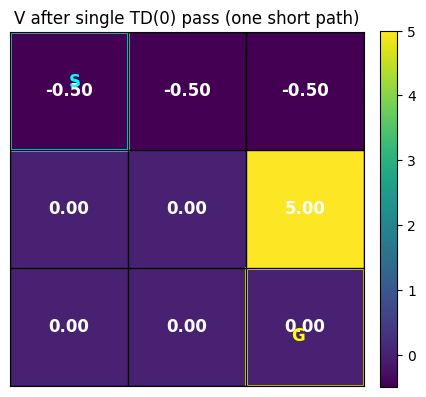

In [10]:
# Demonstration: step-by-step TD(0) updates for the specific short path (the one you asked)
# Path: (3,1)->(3,2)->(3,3)->(2,3)->(1,3) which in s indices is [6,7,8,5,2]
# Use alpha=0.5, gamma=0.9, initial V=0 for all states
alpha = 0.5
gamma = 0.9
V = np.zeros(env.n_states)
path = [env.start_state, env.rc_to_s(2,1), env.rc_to_s(2,2), env.rc_to_s(1,2), env.goal_state]  # [6,7,8,5,2]
print("Path states:", path)
print("Initial V:", V)

# perform immediate TD(0) updates after each transition (as in online TD)
print("\nStep-by-step TD(0) updates (alpha=0.5 gamma=0.9):")
for i in range(len(path)-1):
    s = path[i]
    s_next = path[i+1]
    # determine reward from transition
    if s_next == env.goal_state:
        r = env.goal_reward
    else:
        r = env.step_reward
    # TD target and update
    td_target = r + gamma * V[s_next]
    td_error = td_target - V[s]
    V[s] += alpha * td_error
    print(f"Transition {i+1}: s={s} -> s'={s_next}, reward={r}")
    print(f"  TD target = {td_target:.3f}, TD error = {td_error:.3f}")
    print(f"  Updated V[{s}] = {V[s]:.3f}")
print("\nFinal V after this single pass:", np.round(V, 3))

# Visualize values
plot_grid_values(V, policy=None, title="V after single TD(0) pass (one short path)")


In [11]:
# TD(0) agent (on-policy evaluation under epsilon-greedy behavior)
# We'll use episodic runs starting from start_state, with epsilon exploration.
class TD0Agent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.V = np.zeros(env.n_states)

    def choose_action(self, s):
        # epsilon-greedy over valid actions with uniform random fallback
        valid = self.env.valid_actions(s)
        if not valid:
            return None
        if random.random() < self.epsilon:
            return random.choice(valid)
        # choose action that maximizes V[next_state] (one-step lookahead greedy)
        best_a = None
        best_val = -1e9
        for a in valid:
            s_next, _, _ = self.env.step(s, a)
            val = self.V[s_next]
            if val > best_val:
                best_val = val
                best_a = a
        return best_a

    def run_episode(self, max_steps=50):
        s = self.env.start_state
        total_reward = 0
        steps = 0
        done = False
        while not done and steps < max_steps:
            a = self.choose_action(s)
            if a is None:
                break
            s_next, r, done = self.env.step(s, a)
            total_reward += r
            # TD(0) update
            td_target = r + self.gamma * (0 if done else self.V[s_next])
            td_error = td_target - self.V[s]
            self.V[s] += self.alpha * td_error
            s = s_next
            steps += 1
        return total_reward, steps


In [12]:
#  Q-learning agent (tabular)
class QLearningAgent:
    def __init__(self, env, alpha=0.5, gamma=0.9, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        # Q table shape (n_states x 4 actions), fill unreachable actions with -inf or leave zeros and mask
        self.Q = np.zeros((env.n_states, 4))

    def choose_action(self, s):
        valid = self.env.valid_actions(s)
        if not valid:
            return None
        if random.random() < self.epsilon:
            return random.choice(valid)
        # greedy over valid actions
        qvals = [(a, self.Q[s,a]) for a in valid]
        best_a = max(qvals, key=lambda x: x[1])[0]
        return best_a

    def run_episode(self, max_steps=50):
        s = self.env.start_state
        total_reward = 0
        steps = 0
        done = False
        while not done and steps < max_steps:
            a = self.choose_action(s)
            if a is None:
                break
            s_next, r, done = self.env.step(s, a)
            total_reward += r
            # Q-learning update: off-policy, use max_a' Q(s',a')
            next_q_max = 0 if done else np.max(self.Q[s_next, self.env.valid_actions(s_next)])
            # Note: if s_next is terminal, treat next_q_max as 0
            td_target = r + self.gamma * next_q_max
            td_error = td_target - self.Q[s,a]
            self.Q[s,a] += self.alpha * td_error
            s = s_next
            steps += 1
        return total_reward, steps

    def get_policy(self):
        # derive greedy policy (action index) for each state
        policy = np.full(self.env.n_states, -1, dtype=int)
        for s in range(self.env.n_states):
            if s in self.env.terminal:
                policy[s] = -1
            else:
                valid = self.env.valid_actions(s)
                best_a = max(valid, key=lambda a: self.Q[s,a])
                policy[s] = best_a
        return policy


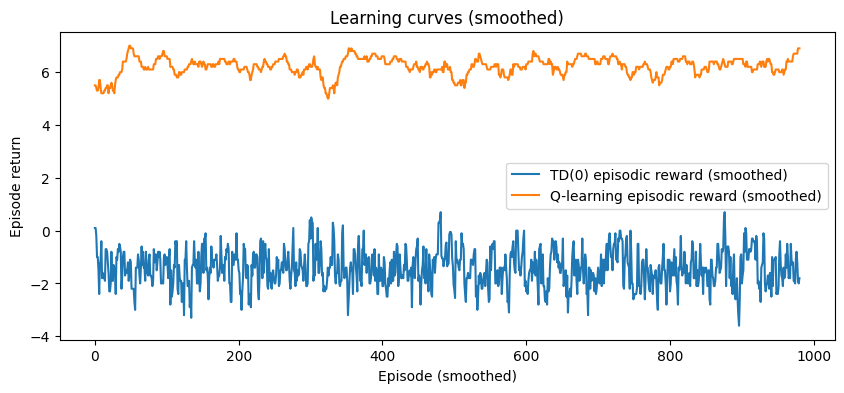

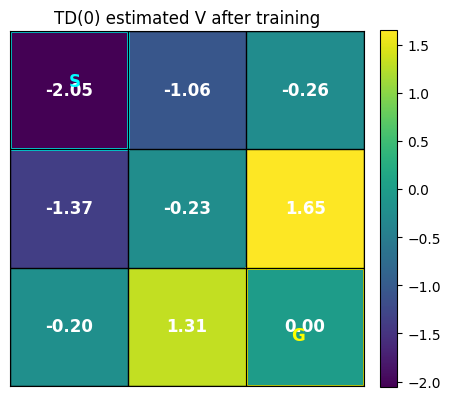

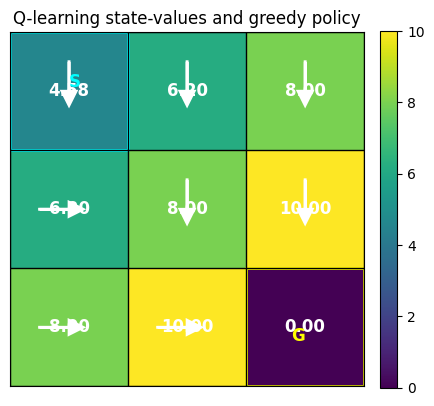

Q-learning greedy policy (per state index 0..8):
0 -> RIGHT
1 -> RIGHT
2 -> GOAL
3 -> RIGHT
4 -> UP
5 -> UP
6 -> UP
7 -> UP
8 -> UP


In [13]:
#  Train TD(0) and Q-learning and plot learning curves & final value/policy
random.seed(0)
np.random.seed(0)

# TD(0) training
td_agent = TD0Agent(env, alpha=0.1, gamma=0.9, epsilon=0.2)
td_rewards = []
n_episodes = 1000
for ep in range(n_episodes):
    r, _ = td_agent.run_episode()
    td_rewards.append(r)

# Q-learning training
q_agent = QLearningAgent(env, alpha=0.5, gamma=0.9, epsilon=0.2)
q_rewards = []
for ep in range(n_episodes):
    r, _ = q_agent.run_episode()
    q_rewards.append(r)

# Smoothed reward plotting
def smooth(x, window=20):
    if len(x) < window:
        return x
    return np.convolve(x, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10,4))
plt.plot(smooth(td_rewards, 20), label='TD(0) episodic reward (smoothed)')
plt.plot(smooth(q_rewards, 20), label='Q-learning episodic reward (smoothed)')
plt.xlabel("Episode (smoothed)")
plt.ylabel("Episode return")
plt.legend()
plt.title("Learning curves (smoothed)")
plt.show()

# Visualize TD estimated state-values
plot_grid_values(td_agent.V, policy=None, title="TD(0) estimated V after training")

# Visualize Q-learning derived state-values (max_a Q(s,a))
q_values_state = np.max(q_agent.Q, axis=1)
plot_grid_values(q_values_state, policy=q_agent.get_policy(), title="Q-learning state-values and greedy policy")

# Print derived greedy policy (action names) for Q-learning
policy = q_agent.get_policy()
print("Q-learning greedy policy (per state index 0..8):")
for s in range(env.n_states):
    if s in env.terminal:
        print(s, "-> GOAL")
    else:
        print(s, "->", env.action_names[policy[s]])


## 3. State-Value Updates

## 2. Bootstrapping Explanation

### What is bootstrapping?

Bootstrapping in RL means updating the value estimate of the current state using:

the immediate reward observed after taking an action, plus

the current estimate of the value of the next state.

For TD(0) (state-value bootstrap) the update for the visited state s after observing reward r and next state s' is:

𝑉
(
𝑠
)
←
𝑉
(
𝑠
)
+
𝛼
(
𝑟
+
𝛾
𝑉
(
𝑠
′
)
−
𝑉
(
𝑠
)
)
V(s)←V(s)+α(r+γV(s
′
)−V(s))

α = learning rate (0 < α ≤ 1).

γ = discount factor (0 ≤ γ ≤ 1).

The term in parentheses is the TD error: δ = r + γ V(s') - V(s).

For Q-learning (action-value bootstrap, off-policy):

𝑄
(
𝑠
,
𝑎
)
←
𝑄
(
𝑠
,
𝑎
)
+
𝛼
(
𝑟
+
𝛾
max
⁡
𝑎
′
𝑄
(
𝑠
′
,
𝑎
′
)
−
𝑄
(
𝑠
,
𝑎
)
)
Q(s,a)←Q(s,a)+α(r+γ
a
′
max
	​

Q(s
′
,a
′
)−Q(s,a))
### Why this is useful in the Christ University robot setting

Online learning: the robot can update immediately after each step — it does not need to wait until an entire episode finishes. Useful when the robot needs to operate and learn during real exam shifts (continuous operation).

Sample efficiency: because it re-uses current estimates V(s'), information about future returns propagates backwards quickly (over multiple updates), so improvements appear faster than waiting for full returns.

Adaptivity in real world: campus layout, obstacles, or temporary detours (e.g., closed corridor during an exam) can change; bootstrapping allows the robot to adapt after a few interactions rather than waiting for terminal episodes.

Low memory & computation: TD(0) updates require only current and successor states, not storing whole trajectories — practical for an onboard robot with limited compute.

### How the Robot Updates the Value of a Current State (Bootstrapping Using TD(0) / Q-learning)

Bootstrapping means the robot updates its current estimate using both:

The immediate reward it receives after taking an action, and

The estimated value of the next state, instead of waiting for the final outcome.

TD(0) Update (State-Value Learning)

When the robot is in state s, takes action a, receives reward r, and reaches next state s′, it updates as:

𝑉
(
𝑠
)
←
𝑉
(
𝑠
)
+
𝛼
(
𝑟
+
𝛾
𝑉
(
𝑠
′
)
−
𝑉
(
𝑠
)
)
V(s)←V(s)+α(r+γV(s
′
)−V(s))

𝑉
(
𝑠
)
V(s): current estimate of how good state s is

𝑟
r: immediate reward (–1 for a step)

𝑉
(
𝑠
′
)
V(s
′
): estimated value of next state (bootstrapped)

𝛼
α: learning rate

𝛾
γ: discount factor

The term:

𝑟
+
𝛾
𝑉
(
𝑠
′
)
r+γV(s
′
)

is the bootstrapped target.
Instead of waiting until the robot reaches the Exam Control Room, the robot uses its current estimate of the future (V(s′)) to improve the estimate of the present (V(s)).

### Q-learning Update (Action-Value Bootstrapping)

Q-learning updates the value of a state–action pair:

𝑄
(
𝑠
,
𝑎
)
←
𝑄
(
𝑠
,
𝑎
)
+
𝛼
(
𝑟
+
𝛾
max
⁡
𝑎
′
𝑄
(
𝑠
′
,
𝑎
′
)
−
𝑄
(
𝑠
,
𝑎
)
)
Q(s,a)←Q(s,a)+α(r+γ
a
′
max
	​

Q(s
′
,a
′
)−Q(s,a))

Here the robot uses the best estimated future action value from the next state:

max
⁡
𝑎
′
𝑄
(
𝑠
′
,
𝑎
′
)
a
′
max
	​

Q(s
′
,a
′
)

This also uses bootstrapping, because the update depends on the current estimated future value, not the complete return.

### Why Bootstrapping is Useful in the Real Christ University Setting

The autonomous service robot operates continuously in a dynamic environment: students move around, corridors become crowded, and during exams certain paths may temporarily be blocked. Bootstrapping offers several advantages:

1. Fast, Online Learning (Updates Happen After Every Step)

The robot does not need to complete the entire trip to update its knowledge.

It learns immediately after each movement:

Reward: –1 for step

Estimate of next state value

Update current state value

This makes learning instant, which is essential when navigating live student traffic.

2. Sample Efficient — Learns from Limited Experience

Campus routes change often (exam hall crowding, doorways opening/closing).

Bootstrapping lets the robot improve quickly even with very few experiences, because every update spreads information backward through the grid.

For example:
If the robot discovers that state near the Exam Control Room has a high value, TD immediately raises the value of states leading to it.

3. Suitable for Continuous, Real-Time Operation

Monte Carlo methods require reaching the final goal (Exam Control Room) before updating.
This is unrealistic because:

The robot may be interrupted,

Episodes may be long,

The robot must operate throughout the day.

Bootstrapping works even if the robot never reaches the goal during an attempt.

4. Adapts Quickly to Real Campus Conditions

If a hallway becomes blocked or crowded, the robot’s value estimates must adjust fast.

#### Bootstrapping updates values immediately when:

A movement becomes costly,

A new shorter path is discovered,

The environment changes.

This allows the robot to continuously refine its navigation strategy.

5. Computationally Light — Runs Easily on a Mobile Robot

Bootstrapping uses only the current state and the next state’s estimate — no large memory or long trajectory storage is needed.

Perfect for small processors on autonomous service robots.

Greedy trajectory (state indices): [6, 3, 4, 1, 2]


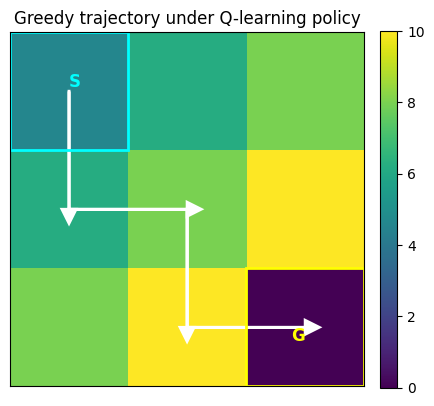

In [14]:
# Show a single greedy trajectory using the learned Q policy (no exploration)
def follow_policy_and_plot(q_agent):
    s = env.start_state
    traj = [s]
    done = False
    steps = 0
    while not done and steps < 20:
        policy = q_agent.get_policy()
        a = policy[s]
        if a == -1:
            break
        s_next, r, done = env.step(s, a)
        traj.append(s_next)
        s = s_next
        steps += 1
    print("Greedy trajectory (state indices):", traj)
    # Visualize trajectory over the grid, overlaying path
    values = np.max(q_agent.Q, axis=1)
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(values.reshape((3,3)), origin='upper', interpolation='nearest')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # draw path arrows between consecutive states
    for i in range(len(traj)-1):
        s_from = traj[i]; s_to = traj[i+1]
        r1,c1 = env.s_to_rc(s_from); r2,c2 = env.s_to_rc(s_to)
        ax.arrow(c1, r1, c2-c1, r2-r1, head_width=0.12, head_length=0.12, fc='white', ec='white', linewidth=2)
    # annotate S and G
    sr, sc = env.s_to_rc(env.start_state); gr, gc = env.s_to_rc(env.goal_state)
    ax.add_patch(patches.Rectangle((sc-0.5, sr-0.5), 1, 1, fill=False, edgecolor='cyan', linewidth=2))
    ax.add_patch(patches.Rectangle((gc-0.5, gr-0.5), 1, 1, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(sc, sr, "S", ha='left', va='bottom', color='cyan', fontsize=12, fontweight='bold')
    ax.text(gc, gr, "G", ha='right', va='top', color='yellow', fontsize=12, fontweight='bold')
    ax.set_xticks([]); ax.set_yticks([])
    plt.gca().invert_yaxis()
    plt.title("Greedy trajectory under Q-learning policy")
    plt.show()

follow_policy_and_plot(q_agent)


##4. Critical Reflection

Bootstrapping (TD(0) / Q-learning) is far more practical than Monte Carlo learning for real-time navigation at Christ University.
Bootstrapping updates values after every step using the current estimate of the next state, enabling fast, online, and incremental learning. This allows the autonomous robot to adapt quickly to dynamic corridor conditions, crowds, and changing routes during examination periods.

In contrast, Monte Carlo learning waits until the robot completes an entire journey before updating, making it too slow, unstable, and unreliable in a constantly changing campus environment where episodes may be interrupted.

Therefore, bootstrapping is the more suitable method for dynamic, real-world navigation tasks in Christ University.

# Question 2

In [15]:
# Imports and settings
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import matplotlib.patches as patches

plt.rcParams.update({'figure.max_open_warning': 0})
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
print("Imports done. Random seed:", SEED)


Imports done. Random seed: 42


In [16]:
# Environment definition (Eighth Floor small graph)
class EighthFloorEnv:
    """
    Deterministic small graph environment representing 8th floor locations.
    States: S0..S7 (8 states)
    Rewards assigned when entering states. Goal is terminal (no outgoing moves).
    """
    def __init__(self):
        self.state_names = [
            "Lab811 (S0)",        # S0: +5 productive
            "Faculty Cabin 812 (S1)",
            "Noisy Corridor (S2)",# S2: -3 noisy
            "Collab Area (S3)",   # S3: +2 collaboration
            "5MSAIM Classroom 815 (S4) [GOAL]", # S4: +10 goal
            "Placement Office (S5)",
            "Open Area (S6) [START]",
            "Storage (S7)"
        ]
        self.n_states = len(self.state_names)
        # Rewards for entering states (not for being in them initially)
        self.rewards = np.zeros(self.n_states)
        self.rewards[0] = +5.0   # Lab811
        self.rewards[2] = -3.0   # Noisy corridor
        self.rewards[3] = +2.0   # Collaboration area
        self.rewards[4] = +10.0  # Goal classroom
        self.rewards[5] = +1.0   # Placement office small positive
        self.rewards[6] = 0.0    # Open area (start)
        self.rewards[7] = -1.0   # Storage small negative

        self.start_state = 6  # Open Area S6 as start
        self.goal_state = 4   # Classroom S4 terminal
        # Graph adjacency (deterministic)
        self.adjacency = {
            0: [1, 3],      # Lab811 <-> Faculty, Collab
            1: [0, 2, 5],   # Faculty <-> Lab, Noisy, Placement
            2: [1, 6],      # Noisy <-> Faculty, Open
            3: [0, 6, 4],   # Collab <-> Lab, Open, Goal
            4: [],          # Goal terminal
            5: [1, 6],      # Placement <-> Faculty, Open
            6: [2, 3, 5, 7],# Open <-> Noisy, Collab, Placement, Storage
            7: [6]          # Storage <-> Open
        }

    def valid_actions(self, s):
        return self.adjacency[s]

    def step(self, s, next_s):
        """Return (s_next, reward, done)"""
        if s == self.goal_state:
            return s, 0.0, True
        if next_s not in self.adjacency[s]:
            # invalid: stay and small penalty
            return s, -1.0, False
        r = self.rewards[next_s]
        done = (next_s == self.goal_state)
        return next_s, r, done

# instantiate
env = EighthFloorEnv()
print("Environment created with", env.n_states, "states. Start:", env.start_state, "Goal:", env.goal_state)


Environment created with 8 states. Start: 6 Goal: 4


In [17]:
# Helper visualization functions (value heatmap and policy arrows)
def plot_value_heatmap(V, title="Value function V(s)", state_names=None):
    """Plot 2x4 grid layout (we'll arrange 8 states in 2 rows for visualization)."""
    arr = np.array(V).reshape((2,4))  # reshape for 2x4 display
    fig, ax = plt.subplots(figsize=(8,4))
    im = ax.imshow(arr, origin='upper', cmap='viridis', interpolation='nearest')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(title)
    for i in range(2):
        for j in range(4):
            s = i*4 + j
            ax.text(j, i, f"S{s}\n{V[s]:.2f}", ha='center', va='center', color='white', fontsize=10, fontweight='bold')
            if state_names is not None:
                ax.text(j, i+0.3, state_names[s], ha='center', va='top', color='white', fontsize=7)
    ax.set_xticks([]); ax.set_yticks([])
    plt.show()

def plot_graph_policy(V, policy, title="Policy (greedy) with state-values"):
    """Simple graph-like plot of nodes in fixed positions with arrows for greedy policy."""
    positions = {
        0: (0,1), 1: (1,1), 2: (2,1), 3: (3,1),
        4: (4,1), 5: (1,0), 6: (2,0), 7: (3,0)
    }
    fig, ax = plt.subplots(figsize=(10,5))
    # draw nodes
    for s, pos in positions.items():
        x,y = pos
        ax.scatter([x],[y], s=600, c='skyblue', edgecolors='k')
        ax.text(x, y, f"S{s}\n{V[s]:.2f}", ha='center', va='center', fontsize=9, fontweight='bold')
    # draw edges (undirected for display)
    for s, nbrs in env.adjacency.items():
        x1,y1 = positions[s]
        for n in nbrs:
            x2,y2 = positions[n]
            ax.plot([x1,x2],[y1,y2], color='gray', linewidth=1, zorder=1)
    # draw policy arrows
    for s in range(env.n_states):
        if s == env.goal_state: continue
        if policy[s] is None: continue
        x1,y1 = positions[s]; x2,y2 = positions[policy[s]]
        dx, dy = x2-x1, y2-y1
        ax.arrow(x1, y1, dx*0.6, dy*0.6, head_width=0.08, head_length=0.12, fc='red', ec='red', linewidth=2)
    ax.set_xlim(-0.5, 4.5); ax.set_ylim(-0.5, 1.5)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(title)
    plt.show()


In [18]:
# Helper visualization functions (value heatmap and policy arrows)
def plot_value_heatmap(V, title="Value function V(s)", state_names=None):
    """Plot 2x4 grid layout (we'll arrange 8 states in 2 rows for visualization)."""
    arr = np.array(V).reshape((2,4))  # reshape for 2x4 display
    fig, ax = plt.subplots(figsize=(8,4))
    im = ax.imshow(arr, origin='upper', cmap='viridis', interpolation='nearest')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(title)
    for i in range(2):
        for j in range(4):
            s = i*4 + j
            ax.text(j, i, f"S{s}\n{V[s]:.2f}", ha='center', va='center', color='white', fontsize=10, fontweight='bold')
            if state_names is not None:
                ax.text(j, i+0.3, state_names[s], ha='center', va='top', color='white', fontsize=7)
    ax.set_xticks([]); ax.set_yticks([])
    plt.show()

def plot_graph_policy(V, policy, title="Policy (greedy) with state-values"):
    """Simple graph-like plot of nodes in fixed positions with arrows for greedy policy."""
    positions = {
        0: (0,1), 1: (1,1), 2: (2,1), 3: (3,1),
        4: (4,1), 5: (1,0), 6: (2,0), 7: (3,0)
    }
    fig, ax = plt.subplots(figsize=(10,5))
    # draw nodes
    for s, pos in positions.items():
        x,y = pos
        ax.scatter([x],[y], s=600, c='skyblue', edgecolors='k')
        ax.text(x, y, f"S{s}\n{V[s]:.2f}", ha='center', va='center', fontsize=9, fontweight='bold')
    # draw edges (undirected for display)
    for s, nbrs in env.adjacency.items():
        x1,y1 = positions[s]
        for n in nbrs:
            x2,y2 = positions[n]
            ax.plot([x1,x2],[y1,y2], color='gray', linewidth=1, zorder=1)
    # draw policy arrows
    for s in range(env.n_states):
        if s == env.goal_state: continue
        if policy[s] is None: continue
        x1,y1 = positions[s]; x2,y2 = positions[policy[s]]
        dx, dy = x2-x1, y2-y1
        ax.arrow(x1, y1, dx*0.6, dy*0.6, head_width=0.08, head_length=0.12, fc='red', ec='red', linewidth=2)
    ax.set_xlim(-0.5, 4.5); ax.set_ylim(-0.5, 1.5)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(title)
    plt.show()


In [19]:
# Training loop, snapshots, and tracking V history
alpha = 0.1
gamma = 0.9
epsilon = 0.1
n_episodes = 1000

agent = TD0Agent(env, alpha=alpha, gamma=gamma, epsilon=epsilon)

snapshots = OrderedDict()
snapshots['init'] = agent.V.copy()

returns = []
V_hist_s0 = []
V_hist_s3 = []

for ep in range(1, n_episodes+1):
    r, steps = agent.run_episode()
    returns.append(r)
    V_hist_s0.append(agent.V[0])
    V_hist_s3.append(agent.V[3])
    if ep == 1:
        snapshots['after_1'] = agent.V.copy()
    if ep == 10:
        snapshots['after_10'] = agent.V.copy()
    if ep == n_episodes:
        snapshots['final'] = agent.V.copy()

# ensure snapshots exist if n_episodes small
if 'after_1' not in snapshots: snapshots['after_1'] = agent.V.copy()
if 'after_10' not in snapshots: snapshots['after_10'] = agent.V.copy()

print("Training completed. Episodes:", n_episodes)


Training completed. Episodes: 1000


In [20]:
# Display V(s) table (initial, after 1, after 10, final)
df_rows = []
for label, V in snapshots.items():
    df_rows.append([label] + [float(round(v,4)) for v in V])
cols = ['when'] + [f"S{i}" for i in range(env.n_states)]
df_V = pd.DataFrame(df_rows, columns=cols).set_index('when')
print("V(s) snapshots:")
display(df_V)


V(s) snapshots:


,S0,S1,S2,S3,S4,S5,S6,S7
when,,,,,,,,
init,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000
after_1,6.0721,0.5411,-0.0270,7.7088,0.0,0.0000,0.5259,0.0000
after_10,22.0052,8.0981,-0.0270,22.0308,0.0,0.5129,13.0254,0.0000
final,29.6990,27.6018,21.0423,28.0066,0.0,20.9827,26.4631,20.6551


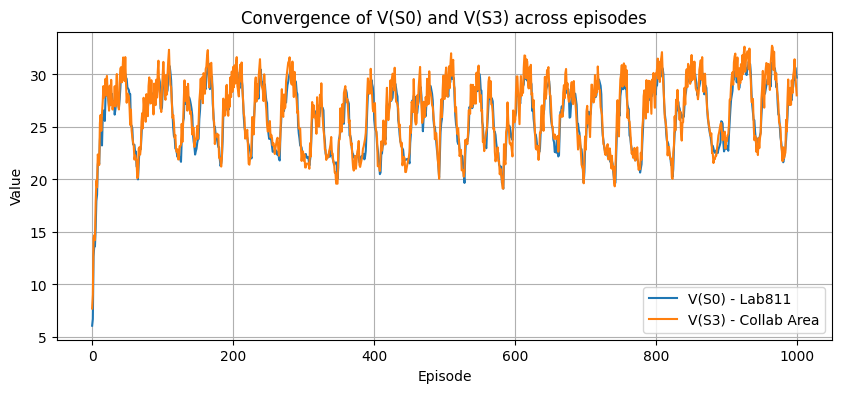

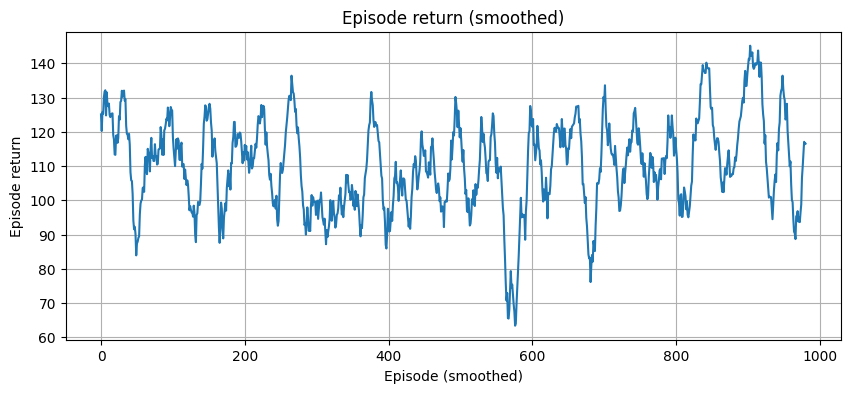

In [21]:
# Plot convergence for S0 and S3 and episode returns
plt.figure(figsize=(10,4))
plt.plot(V_hist_s0, label='V(S0) - Lab811')
plt.plot(V_hist_s3, label='V(S3) - Collab Area')
plt.xlabel("Episode")
plt.ylabel("Value")
plt.title("Convergence of V(S0) and V(S3) across episodes")
plt.legend()
plt.grid(True)
plt.show()

# Plot episode returns (smoothed)
def smooth(x, w=20):
    if len(x) < w: return x
    return np.convolve(x, np.ones(w)/w, mode='valid')

plt.figure(figsize=(10,4))
plt.plot(smooth(returns, 20))
plt.xlabel("Episode (smoothed)")
plt.ylabel("Episode return")
plt.title("Episode return (smoothed)")
plt.grid(True)
plt.show()


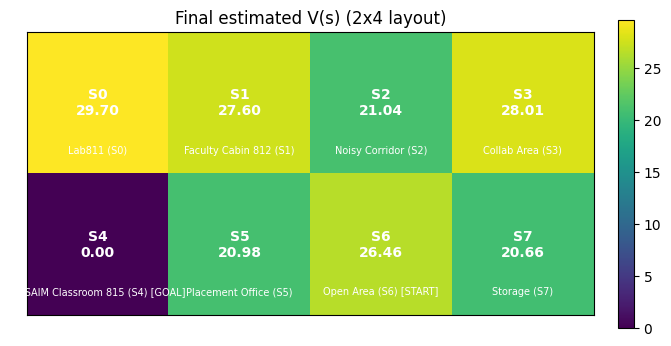

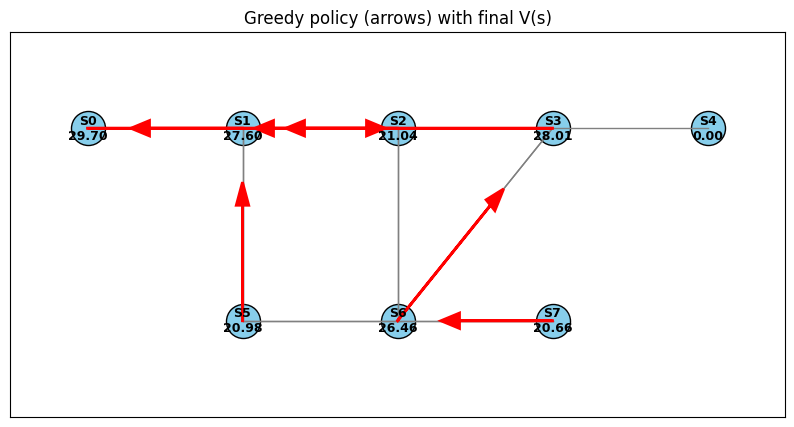

Final V(s):
S0: Lab811 (S0) -> 29.6990
S1: Faculty Cabin 812 (S1) -> 27.6018
S2: Noisy Corridor (S2) -> 21.0423
S3: Collab Area (S3) -> 28.0066
S4: 5MSAIM Classroom 815 (S4) [GOAL] -> 0.0000
S5: Placement Office (S5) -> 20.9827
S6: Open Area (S6) [START] -> 26.4631
S7: Storage (S7) -> 20.6551


In [22]:
# Visualize final value heatmap and greedy policy
final_V = snapshots['final']
# derive greedy policy (choose neighbor with highest V[next])
policy = [None]*env.n_states
for s in range(env.n_states):
    nbrs = env.valid_actions(s)
    if len(nbrs) == 0:
        policy[s] = None
    else:
        policy[s] = max(nbrs, key=lambda ns: final_V[ns])

plot_value_heatmap(final_V, title="Final estimated V(s) (2x4 layout)", state_names=env.state_names)
plot_graph_policy(final_V, policy, title="Greedy policy (arrows) with final V(s)")

# Print final V with readable names
print("Final V(s):")
for i, v in enumerate(final_V):
    print(f"S{i}: {env.state_names[i]} -> {v:.4f}")


In [23]:
# One worked TD(0) numeric update (explicit numbers)
s = 6; s_next = 3  # example: Open Area -> Collab Area
r = env.rewards[s_next]
V_s = snapshots['final'][s]
V_snext = snapshots['final'][s_next]
alpha_used = alpha; gamma_used = gamma
td_target = r + (0.0 if s_next==env.goal_state else gamma_used * V_snext)
td_error = td_target - V_s
new_V_s = V_s + alpha_used * td_error

print("Worked TD(0) numeric example:")
print(f"Transition: S{s} ({env.state_names[s]}) -> S{s_next} ({env.state_names[s_next]})")
print(f"Reward r = {r}")
print(f"V(s) = {V_s:.4f}, V(s') = {V_snext:.4f}")
print(f"alpha = {alpha_used}, gamma = {gamma_used}")
print(f"TD target = {td_target:.4f}")
print(f"TD error = {td_error:.4f}")
print(f"Updated V(s) = {new_V_s:.4f}")


Worked TD(0) numeric example:
Transition: S6 (Open Area (S6) [START]) -> S3 (Collab Area (S3))
Reward r = 2.0
V(s) = 26.4631, V(s') = 28.0066
alpha = 0.1, gamma = 0.9
TD target = 27.2059
TD error = 0.7429
Updated V(s) = 26.5373


## Critical analysis

TD(0) bootstraps by using its current estimate of the next state's value
𝑉
(
𝑠
′
)
V(s
′
) to update the value of the current state
𝑉
(
𝑠
)
V(s). This allows it to update after every step, long before the episode ends.
In the 8th-floor corridor, this enables the robot to learn continuously while walking through rooms, adapting quickly to noisy corridors, productive areas, or changes in hallway conditions.

Impact of α and γ

α (learning rate):
Higher α makes learning faster but unstable; lower α slows learning.
Recommended: 0.1–0.2 for smooth but responsive updating in a dynamic corridor.

γ (discount factor):
Determines how much future rewards matter.
Recommended: 0.9, so the robot values both intermediate productive rooms and the final classroom goal.

## Comparison &amp; Reflection

### Sample efficiency

TD(0): More sample-efficient. Because it bootstraps (uses
𝑟
+
𝛾
𝑉
(
𝑠
′
)
r+γV(s
′
)) it updates after every step and propagates information backward quickly, so fewer interactions are needed to improve estimates.

Monte Carlo (MC): Less sample-efficient. MC must wait for full episode returns
𝐺
G before updating, so useful learning happens only when complete trajectories to terminal states are observed.

### Variance

TD(0): Lower variance. Targets use current value estimates
𝑉
(
𝑠
′
)
V(s
′
) (biased), which reduces the variance of updates and yields steadier, faster convergence in practice.

MC: Higher variance. Uses actual sample returns (random sums of rewards), which are unbiased but can vary a lot between episodes — this slows learning and makes updates noisy.

### Other practical differences

Interruption / continuing tasks: TD(0) works naturally for continuing tasks and interrupted runs. MC requires complete episodes — problematic if the robot is stopped, redirected, or the task never terminates.

Computation & memory: TD(0) needs only current and next-state values; MC must store full trajectories (higher memory).

Bias vs. consistency: MC gives unbiased estimates in the limit; TD(0) introduces bias via bootstrapping but usually converges faster and with less data.

### Which to prefer for an on-the-fly campus robot?

Prefer TD(0) (or action-value variants like SARSA/Q-learning).
Reasons: updates after every step (online, immediate learning), robust to interrupted episodes and dynamic changes (crowds, blocked corridors), lower variance and higher sample efficiency (fewer real-world interactions needed), and lighter memory/computation — all critical for a robot operating continuously on campus.

Short recommendation: Use TD(0)/SARSA for on-line prediction and Q-learning/SARSA for learning a navigation policy, with moderate α (≈0.05–0.2) and γ≈0.9 — then supplement with safe exploration and occasional offline batch updates if needed.